# Variant analysis for Pseudomonas 14 

Int his notebook we are goingo to analyse the merged output files of SNPeff variants annotation and SnpSift fields extract.

In [1]:
!conda create -y -n p14 biopython


Fetching package metadata ...^C
Traceback (most recent call last):
  File "/Users/delphinel/anaconda/envs/jupyterserv/bin/conda", line 6, in <module>
    sys.exit(conda.cli.main())
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 182, in main
    return conda_exception_handler(_main, *args)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/exceptions.py", line 640, in conda_exception_handler
    return_value = func(*args, **kwargs)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 140, in _main
    exit_code = args.func(args, p)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main_create.py", line 68, in execute
    install(args, parser, 'create')
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/install.py", line 231, in install
    unknown=index_args['unknown'], prefix=prefix)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/com

In [3]:
!source activate pa14

Installation of necessary libraries

In [8]:
!conda install -y -c anaconda biopython
!conda install -y -c anaconda networkx 
!conda install -y -c biocore mafft 
!conda install -y -c conda-forge seaborn 
!conda install -y -c etetoolkit ete3 
!conda install -y pandasql

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

Importation of necessary libraries

In [5]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import pylab
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces, AttrFace
pysqldf = lambda q: sqldf(q, globals())

### Plotting Strand Bias

The strand Bias is a sequencing bias that result in an inbalance of infered genotype from the positive and negative strand. We want to eliminate the variants where the strand bias is too high.

The strand bias has been calculated on Galaxy using the tool "compute on column" using the following equations (from https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666) :  


Calculation Strand Bias : 

 a -  Forward strand reference allele = SRF column (5) 

 b - Forward strand non reference allele = SAF column (7) 

 c - Reverse strand reference allele = SRR column (6) 

 d - Reverse strand non reference allele = SAR column (8) 

``` SB: SB is defined as ∣∣(b/(a+b))−(d/(c+d))∣∣/((b+d)/(a+b+c+d))
SB =  ∣∣(SAF/(SRF+SAF))−(SAR/(SRR+SAR))∣∣/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((SAF/(SRF+SAF))−(SAR/(SRR+SAR)))/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((c7/(c5+c7))−(c8/(c6+c8)))/((c7+c8)/(c5+c7+c6+c8))  (Formula applied in Compute Column tool)```

Import of the file resulting of collection collapse snpsift output collection, and plotting of the Strand Bias repartition

/Users/delphinel/anaconda/envs/jupyterserv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


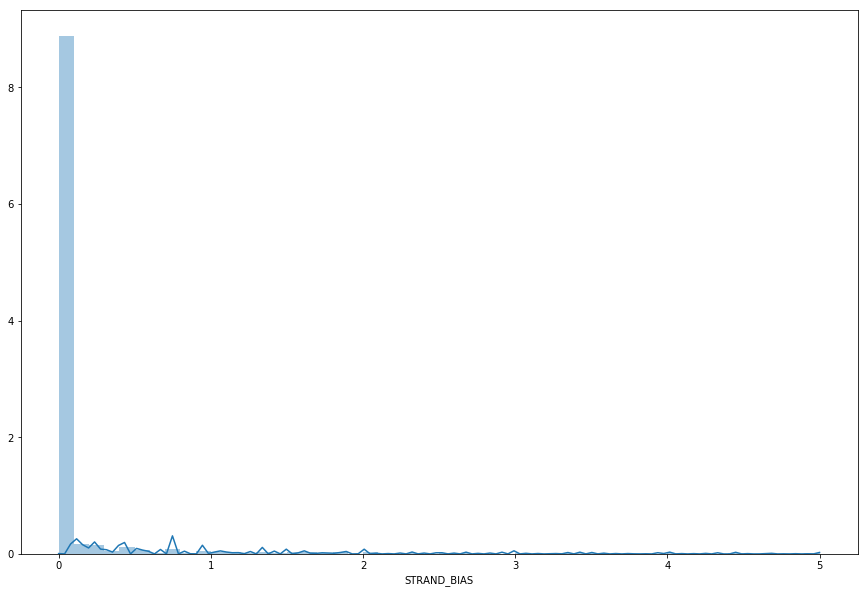

In [6]:
collapsed = pd.read_table('Galaxy4219-[Collapse_Collection_on_data_4218,_data_4217,_and_others].tabular')
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 10) ) 
sns.distplot(collapsed["STRAND_BIAS"]);


We can see that the Strand Bias is in majority <2 , we therefore applied a filter to the snpsift output to select the variants with a Strand Bias <2 

##  Importation and cleaning of input files

Parameters of input files : 
        - EFFECT!='intergenic_region'  : Keep only the variants in intragenic regions
        - ',' not in ALT : Keep only the variants with one allele
        - strand_bias<0.001
        -  (SAR + SAF ) > 10
        

In [7]:
joined = pd.read_table('Galaxy928-[Column_Join_on_data_927,_data_926,_and_others].tabular')

Replacing problematic caracters in the column names

In [8]:
for i in joined.columns.values : 
    joined=joined.rename(index=str, columns={i:i.replace('.','_')})
    joined=joined.rename(index=str, columns={i:i.replace('[*]','_')})

In [9]:
sequences=joined.copy()

Get lists of Columns of interest : containing the ref and alt sequences, and the metrics


In [10]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(ALT)|(REF)|(SRF)|(_SRR)|(SAF)|(SAR)|(STRAND_BIAS)|(var_id).*")
listrefsalts=filter(lambda i: not regexclean.search(i),joined.columns.values)


Keep only \_REF and \_ALT columns, delete the other ones

In [11]:
for i in listrefsalts[1:]:
    del sequences[i]

Creation of a Column that will contain the reference sequence. Setting it at 'NaN' for the moment


In [12]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['REF']="NaN"

Parsing the dataframe to find a collumn containing the reference sequence. Setting the 'REF' column with its content

In [13]:
for i, row in sequences.iterrows() :
    for j in listREF :
        if row[j]!='.':
            sequences.loc[i,('REF')]=row[j]
            break

Deleting the collumns containing the reference sequence, now redundant with 'REF' clumn

In [14]:
for i in listREF:
    del sequences[i]


In the Dataframe, replaceing every instance of '.', meaning there is no variant, with the reference sequence

In [15]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_ALT']=='.':
            sequences.loc[i,(j+'_fq_ALT')]=row['REF']

Other Option : In the Dataframe, replaceing every instance of '.', meaning there is no variant, with the reference sequence, when there is a variant, if the variant count< ref count, replace by ref sequence

In [18]:
#for i, row in sequences.iterrows() :
#    for j in listsamples :
#        if row[j+'_fq_ALT']=='.':
#            sequences.loc[i,(j+'_fq_ALT')]=row['REF']
#        elif (int(row[j+'_fq_SRF'])+int(row[j+'_fq_SRR'])) > (int(row[j+'_fq_SAF'])+int(row[j+'_fq_SAR'])) or (int(row[j+'_fq_SAF'])+int(row[j+'_fq_SAR']))<10 : 
#            sequences.loc[i,(j+'_fq_ALT')]=row['REF']


Saving the resulting mdataframe in a file

In [19]:
sequences.to_csv('matrix_sequence_nonFs_allvar.tab',sep='\t')

Removing variants where ref and alt have different lengths

Creating a Fasta file containing the concatenated sequences

In [20]:
ouptutfasta=open("samplevariants_mostrep.fasta","w")
for j in listsamples :
    ouptutfasta.write(">"+j+"\n"+"".join(sequences[j+"_fq_ALT"])+"\n")
ouptutfasta.close()

In [21]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if len(row[j+"_fq_ALT"])!=  len(row['REF']):
            sequences=sequences.drop(i)
            break

In [22]:
ouptutfasta=open("samplevariants_nonFS_mostrep.fasta","w")
for j in listsamples :
    ouptutfasta.write(">"+j+"\n"+"".join(sequences[j+"_fq_ALT"])+"\n")
ouptutfasta.close()

In [23]:
for i in listALT:
    sequences=sequences.rename(index=str, columns={i:i.replace("_fq_ALT","")})

Aligning the sequences with MAFFT (Allows to resolve gaps in cas the REF and ALT sequences are of different lengths)

In [24]:
!mafft --auto samplevariants_mostrep.fasta > samplevariants_align_nonFs_mostrep.fasta


##### atgcfreq = 1.000000
nseq =  82
distance =  local
iterate =  16
cycle =  1
nthread = 0
lastonce = 0
generating a scoring matrix for nucleotide (dist=200) ... done
done
done
scoremtx = -1
   80 / 82

##### writing hat3
pairlocalalign (nuc) Version 7.245 alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
0 thread(s)
minimumweight = 0.000500
nthread = 0
blosum 62 / kimura 200
sueff_global = 0.100000
Loading 'hat3' ... 
done.
generating a scoring matrix for nucleotide (dist=200) ... done
done
done
scoremtx = -1
Gap Penalty = -1.53, +0.00, +0.00
Loading 'hat2' ... done.
Constructing a UPGMA tree ... 
   80 / 82
done.

Progressive alignment ... 
STEP    75 /81 c
Reallocating..done. *alloclen = 5276
STEP    81 /81 c
done.
tbfast (nuc) Version 7.245 alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)
minimumweight = 0.000500
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global 

Opening the output of MAFFT , convert to upper case and compute the distance matrix

In [25]:
alignementfile=open('samplevariants_align_nonFs_mostrep.fasta','r')
upperalignmentfile=open('samplevariants_align_upper_nonFs.fasta','w')
alignment=alignementfile.read().upper()
upperalignmentfile.write(alignment)
alignementfile.close()
upperalignmentfile.close()
aln = AlignIO.read('samplevariants_align_upper_nonFs.fasta', 'fasta')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)
Phylo.write(tree,'pa14_nonFs_aligned_mostrep.nwk', 'newick')

1

Compute the distance matrix for the non aligned fasta file

In [26]:
aln = AlignIO.read('samplevariants_nonFs_mostrep.fasta', 'fasta')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)
Phylo.write(tree,'pa14_nonFs_unaligned_mostrep.nwk', 'newick')

1

Build a tree from the Distance MAtrix (Here using neighor joining algorithm) and saving it in a newick file

### Draw Tree from a Newick File

Open Treefile

Set drawing style, title, and color per condition

In [43]:
from ete3 import Tree,TextFace, TreeStyle

In [47]:
condlist=list()
for i in listsamples:
    condition=i[-3:]
    if condition not in condlist:
        condlist.append(condition)
colors=['red','blue','purple','black','pink','green','lightblue','brown','yellow', 'orange']
colcondDisct={}
for i in range(len(condlist)):
    colcondDisct[condlist[i]]=colors[i]
colorleaves= {}
for i in listsamples:
    condition=i[-3:]
    colorleaves[i.upper()]=colcondDisct[condition]
    

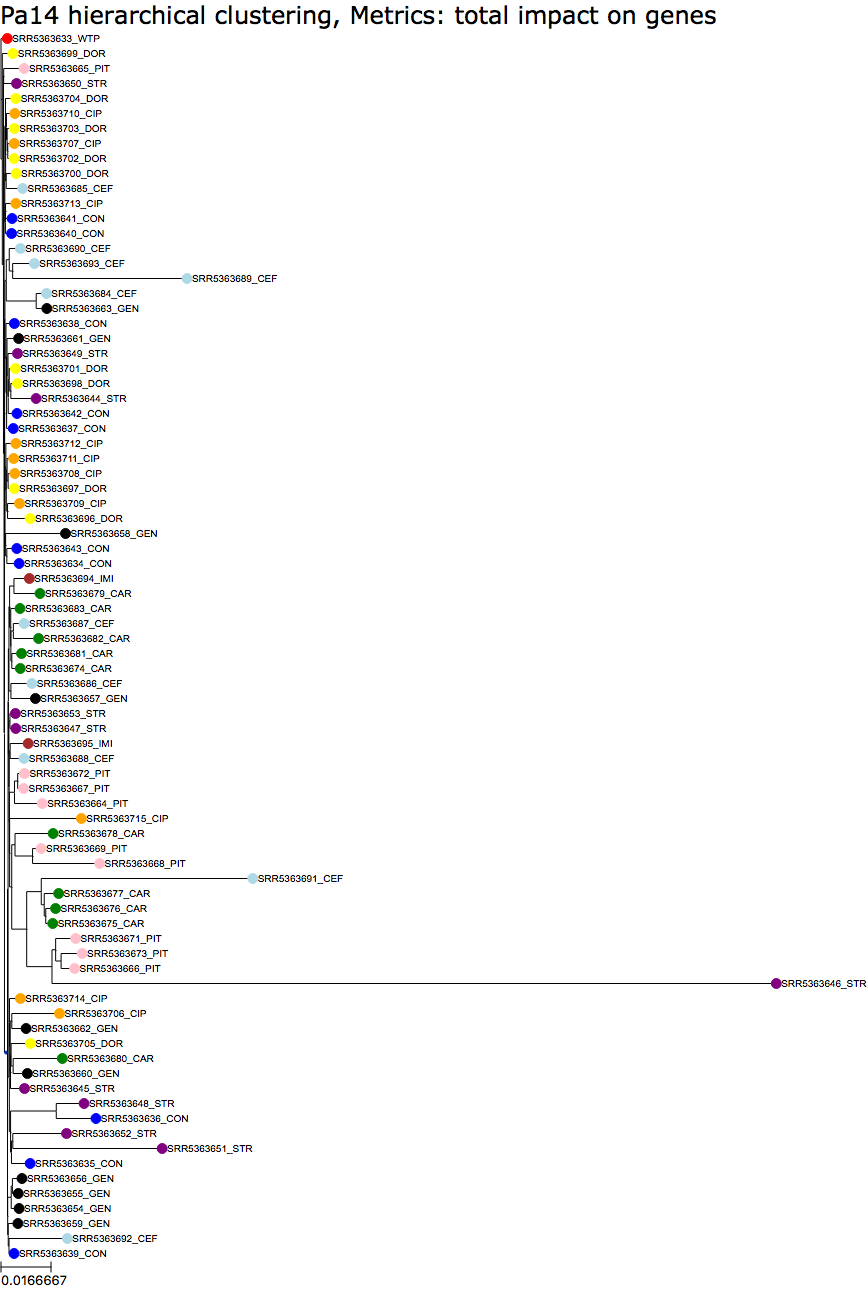

In [54]:
tree = Tree("pa14_nonFs_aligned_mostrep.nwk", format=1)

ts = TreeStyle()
ts.title.add_face(TextFace("Pa14 hierarchical clustering, Metrics: total impact on genes", fsize=24), column=0)
#ts.mode="c"
ts.scale =  3000 
ts.branch_vertical_margin = 3
ts.show_branch_length = False
ts.show_branch_support = False

for node in tree.traverse():
    node.img_style['size']=0
    if node.is_leaf():
        node.img_style['size']=10
        node.img_style["fgcolor"] = colorleaves[node.name]
                                                 
tree.set_outgroup("SRR5363633_WTP") # Set the wildtype as outgroup

tree.render("%%inline", tree_style=ts)

Render tree in the jupyter notebook

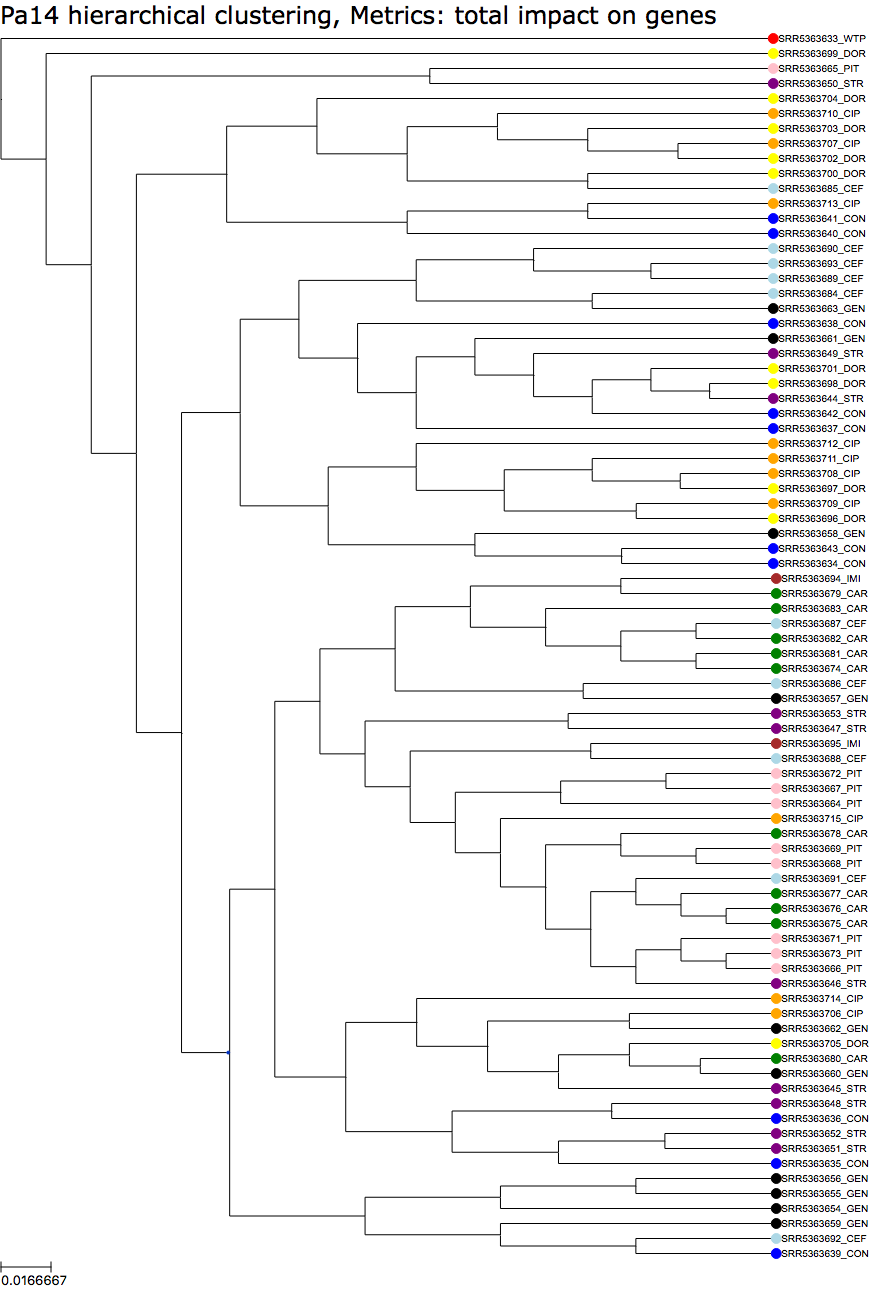

In [55]:
tree.convert_to_ultrametric(strategy='balanced')
tree.render("%%inline", tree_style=ts)


In [56]:
condlist=list()
for i in listsamples:
    condition=i[-3:]
    if condition not in condlist:
        condlist.append(condition)
colors=['red','blue','purple','black','pink','green','lightblue','brown','yellow', 'orange']
colcondDisct={}
for i in range(len(condlist)):
    colcondDisct[condlist[i]]=colors[i]
colorleaves= {}
for i in listsamples:
    condition=i[-3:]
    colorleaves[i]=colcondDisct[condition]

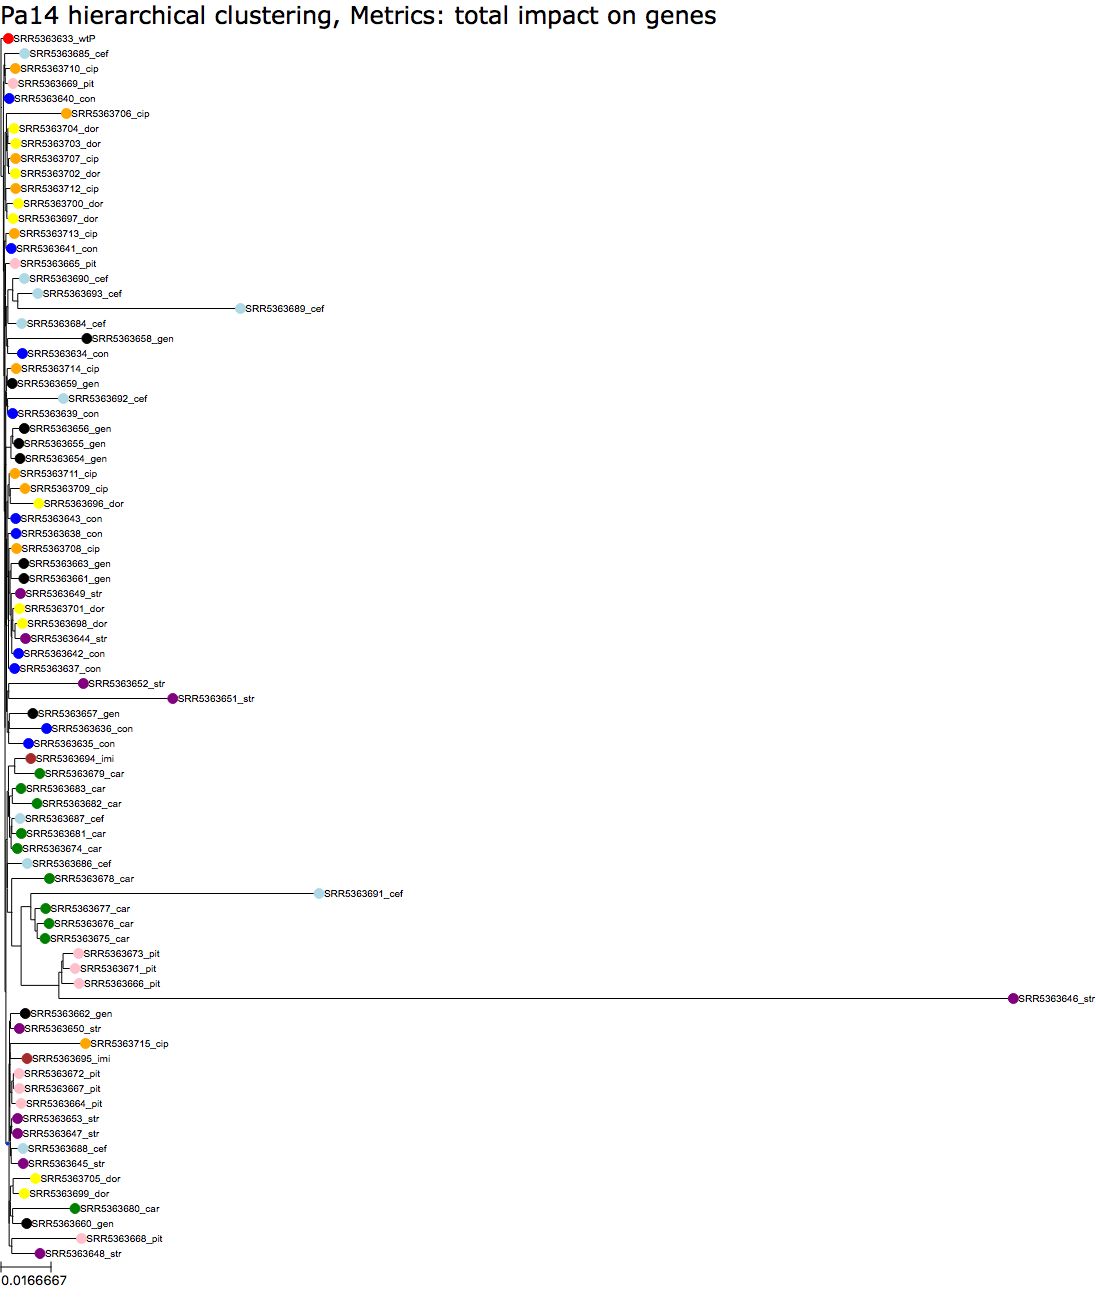

In [61]:
tree = Tree("pa14_nonFs_unaligned_mostrep.nwk", format=1)


ts = TreeStyle()
ts.title.add_face(TextFace("Pa14 hierarchical clustering, Metrics: total impact on genes", fsize=24), column=0)
#ts.mode="c"
ts.scale =  3000 
ts.branch_vertical_margin = 3
ts.show_branch_length = False
ts.show_branch_support = False

for node in tree.traverse():
    node.img_style['size']=0
    if node.is_leaf():
        node.img_style['size']=10
        node.img_style["fgcolor"] = colorleaves[node.name]
                                                 
tree.set_outgroup("SRR5363633_wtP") # Set the wildtype as outgroup

tree.render("%%inline", tree_style=ts)


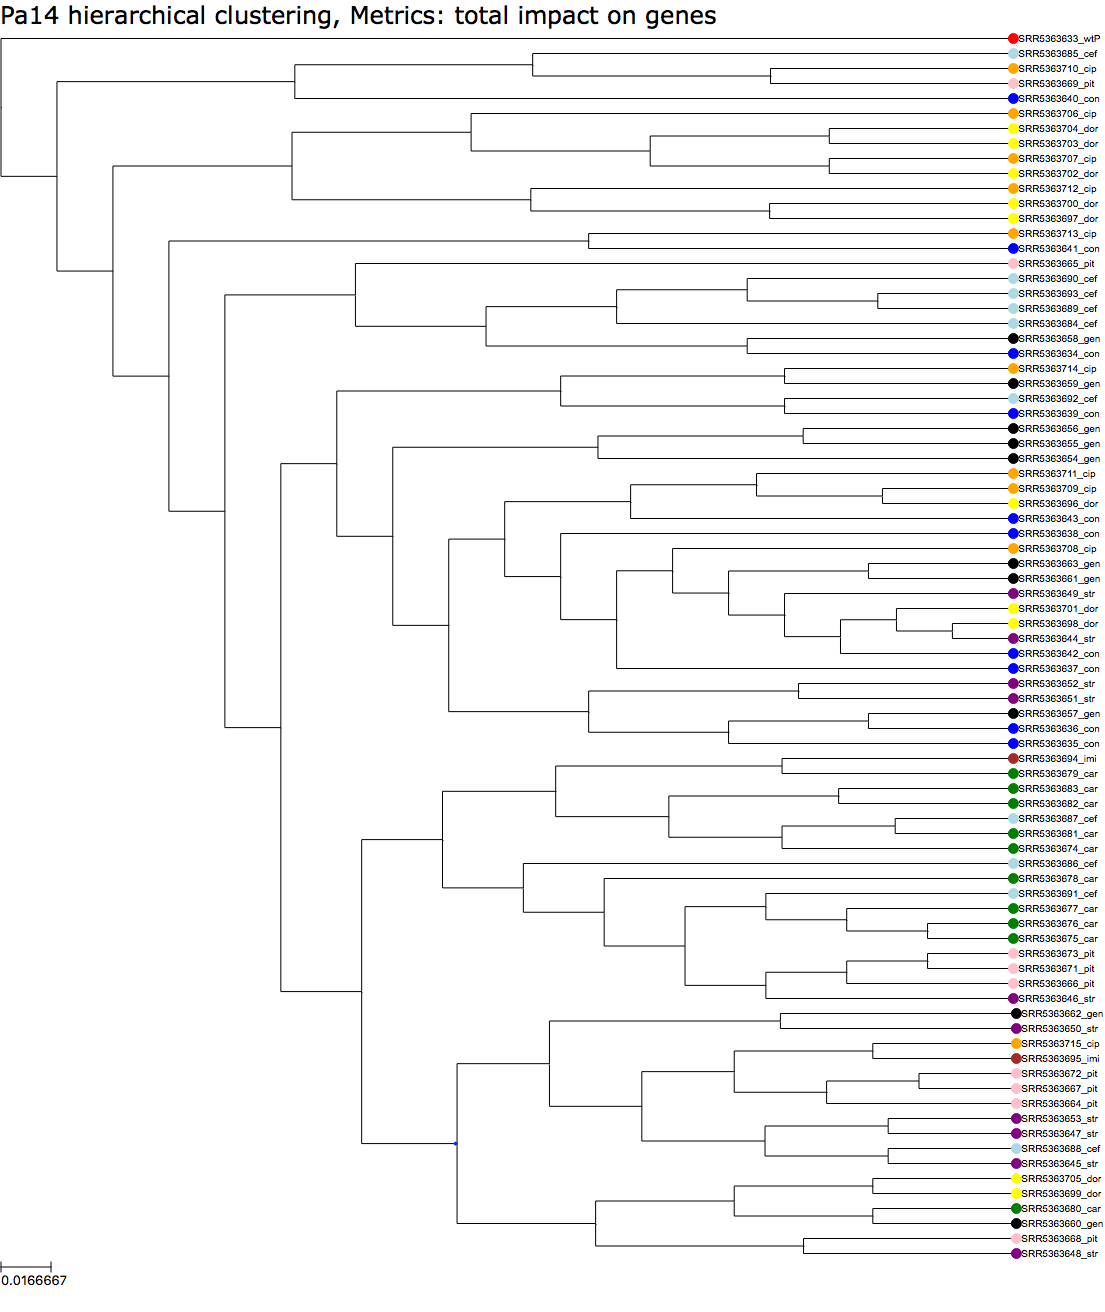

In [63]:
tree.convert_to_ultrametric(strategy='balanced')
tree.render("%%inline", tree_style=ts)